In [1]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### **1. Loading the Data**
In this part, we load the dataset from a CSV file and preprocess it. We also convert the difficulty levels into numeric labels for classification.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

file_path = "./Data/CEFR_GERMAN_sentences_labelled.csv"

# Load your dataset
data = pd.read_csv(file_path)

# Create a new coloumn to store the difficulty labels
data["difficulty_label"] = data["difficulty_reviewed"]

# Convert difficulty column to numeric labels
data["difficulty"] = data["difficulty_reviewed"].astype("category").cat.codes

# Display the first few rows of the dataset
display(data.head(10))

# Display the number of samples in each difficulty category
data["difficulty"].value_counts()

/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Auf dem Foto ist eine Stadt am Meer.,0,481,8,NaN,NaN,A1,105.66,A1
1,„Florian will gern ins Schwimmbad gehen.,0,486,6,NaN,NaN,A1,73.85,A1
2,Wir essen um 15 Uhr zusammen.,0,526,6,NaN,NaN,A1,90.77,A1
3,Dort geht man von Raum zu Raum.,0,316,7,9.0,112.0,A1,115.13,A1
4,Das Holländische Viertel mitten in Potsdam.,0,485,6,11.0,117.0,A1,48.47,A1
5,Heute ist Potsdam eine moderne Stadt.,0,485,6,8.0,113.0,A1,90.77,A1
6,Dann suchen Laura und Kilian ihre Plätze.,0,509,7,NaN,NaN,A1,89.75,A1
7,Der Schaffner gibt Tim die Fahrkarte und geht ...,0,498,9,NaN,NaN,A1,96.18,A1
8,Dann gehen Anna und Lisa zusammen nach Hause.,0,500,8,NaN,NaN,A1,88.74,A1
9,"„Ja, das sehe ich“, antwortet der Mann.",0,502,7,NaN,NaN,A1,106.67,A1


difficulty
0    587
1    587
2    587
3    587
4    587
5    587
Name: count, dtype: int64

### **2. Splitting the Dataset**
Here, we split the dataset into training, test sets using an 80%-20% split. Stratification ensures that class distribution is preserved across splits.

In [3]:
# Split the data into train (80%) and test (10%)
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["difficulty"], random_state=42)


print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2817
Test size: 705


In [17]:
# save the train and test data to csv
train_data.to_csv("./Data/train_data.csv", index=False)
test_data.to_csv("./Data/test_data.csv", index=False)


### **3. Preparing the Hugging Face Dataset**
In this step, we convert the dataset into the Hugging Face `Dataset` format and create a `DatasetDict` for easier handling in the `transformers` library.

In [4]:
# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_pandas(test_data)
train_dataset = Dataset.from_pandas(train_data)

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'difficulty', 'text_id', 'sentence_length', 'sentence_tokens', 'total_tokens_per_call', 'difficulty_reviewed', 'readability', 'difficulty_label', '__index_level_0__'],
        num_rows: 2817
    })
    test: Dataset({
        features: ['sentence', 'difficulty', 'text_id', 'sentence_length', 'sentence_tokens', 'total_tokens_per_call', 'difficulty_reviewed', 'readability', 'difficulty_label', '__index_level_0__'],
        num_rows: 705
    })
})



### **4. Tokenizing the Dataset**
Here, we load the tokenizer for `xlm-roberta-base` and tokenize the sentences. We also assign numeric labels for classification.

In [5]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Tokenize the dataset and add the `labels` field
def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Assign numeric labels
    tokenized_inputs["labels"] = examples["difficulty"]
    return tokenized_inputs

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True, num_proc=4)  # Use 4 processes


# Debugging: Check tokenized dataset
print(tokenized_datasets["train"][0])

Map (num_proc=4):   0%|          | 0/2817 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/705 [00:00<?, ? examples/s]

{'sentence': 'Zur Vorbereitung sollte man mit einem Arm eine weit ausholende Bewegung machen, so als wolle man jemanden freudig begrüßen.', 'difficulty': 3, 'text_id': '306', 'sentence_length': 19, 'sentence_tokens': 27.0, 'total_tokens_per_call': 139.0, 'difficulty_reviewed': 'B2', 'readability': 69.11, 'difficulty_label': 'B2', '__index_level_0__': 2172, 'input_ids': [0, 47426, 150754, 12961, 332, 491, 2315, 33119, 909, 30604, 1312, 71427, 112, 92658, 8960, 4, 221, 737, 13924, 133, 332, 40127, 33, 12478, 34, 4803, 225749, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 


### **5. Loading the Model**
In this step, we load the pre-trained `xlm-roberta-base` model and prepare it for sequence classification by specifying the number of labels.

In [6]:
import torch
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [7]:
from transformers import AutoModelForSequenceClassification

# Define the number of classes
num_classes = len(data["difficulty"].unique())
print(f"Number of classes: {num_classes}")

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=num_classes)

model.to(device) # Move the model to the device

Number of classes: 6


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=


### **6. Setting Up the Trainer**
We define the training arguments and initialize the `Trainer` class, which manages the fine-tuning process. Early stopping is implemented to prevent overfitting.


In [8]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

# Define a data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # Adjusted learning rate
    lr_scheduler_type="linear",  # Gradually reduces learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/wb/btfl8bv91b5c253kbpftk1940000gn/T/ipykernel_23019/4216458826.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### **7. Training the Model**
Finally, we start the training process and fine-tune the model for the text classification task.


In [9]:
# Train the model
trainer.train()

  0%|          | 0/1760 [00:00<?, ?it/s]

{'loss': 1.797, 'grad_norm': 7.198448181152344, 'learning_rate': 9.943181818181819e-06, 'epoch': 0.06}
{'loss': 1.7979, 'grad_norm': 6.460068702697754, 'learning_rate': 9.886363636363637e-06, 'epoch': 0.11}
{'loss': 1.7904, 'grad_norm': 8.516172409057617, 'learning_rate': 9.829545454545455e-06, 'epoch': 0.17}
{'loss': 1.7866, 'grad_norm': 9.60258960723877, 'learning_rate': 9.772727272727273e-06, 'epoch': 0.23}
{'loss': 1.794, 'grad_norm': 11.67725944519043, 'learning_rate': 9.715909090909091e-06, 'epoch': 0.28}
{'loss': 1.7365, 'grad_norm': 11.830154418945312, 'learning_rate': 9.65909090909091e-06, 'epoch': 0.34}
{'loss': 1.7019, 'grad_norm': 13.37597370147705, 'learning_rate': 9.602272727272727e-06, 'epoch': 0.4}
{'loss': 1.6869, 'grad_norm': 19.89876365661621, 'learning_rate': 9.545454545454547e-06, 'epoch': 0.45}
{'loss': 1.5382, 'grad_norm': 18.209821701049805, 'learning_rate': 9.488636363636365e-06, 'epoch': 0.51}
{'loss': 1.5048, 'grad_norm': 20.198890686035156, 'learning_rate': 

  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 1.0817681550979614, 'eval_runtime': 18.3676, 'eval_samples_per_second': 38.383, 'eval_steps_per_second': 4.845, 'epoch': 1.0}
{'loss': 1.1581, 'grad_norm': 116.0140609741211, 'learning_rate': 8.977272727272727e-06, 'epoch': 1.02}
{'loss': 1.2044, 'grad_norm': 41.478755950927734, 'learning_rate': 8.920454545454547e-06, 'epoch': 1.07}
{'loss': 1.1989, 'grad_norm': 48.511539459228516, 'learning_rate': 8.863636363636365e-06, 'epoch': 1.13}
{'loss': 1.2008, 'grad_norm': 27.07062339782715, 'learning_rate': 8.806818181818183e-06, 'epoch': 1.19}
{'loss': 1.1501, 'grad_norm': 39.244117736816406, 'learning_rate': 8.750000000000001e-06, 'epoch': 1.24}
{'loss': 1.1521, 'grad_norm': 29.411073684692383, 'learning_rate': 8.693181818181819e-06, 'epoch': 1.3}
{'loss': 1.1549, 'grad_norm': 16.8337345123291, 'learning_rate': 8.636363636363637e-06, 'epoch': 1.36}
{'loss': 1.0516, 'grad_norm': 29.1236572265625, 'learning_rate': 8.579545454545455e-06, 'epoch': 1.41}
{'loss': 1.2262, 'grad_norm

  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 0.9280887246131897, 'eval_runtime': 20.0929, 'eval_samples_per_second': 35.087, 'eval_steps_per_second': 4.429, 'epoch': 2.0}
{'loss': 0.8572, 'grad_norm': 33.86223602294922, 'learning_rate': 7.954545454545455e-06, 'epoch': 2.03}
{'loss': 0.9438, 'grad_norm': 43.58577346801758, 'learning_rate': 7.897727272727273e-06, 'epoch': 2.09}
{'loss': 1.0011, 'grad_norm': 46.01958465576172, 'learning_rate': 7.840909090909091e-06, 'epoch': 2.15}
{'loss': 0.9089, 'grad_norm': 29.950708389282227, 'learning_rate': 7.784090909090911e-06, 'epoch': 2.2}
{'loss': 1.0381, 'grad_norm': 54.67460632324219, 'learning_rate': 7.727272727272727e-06, 'epoch': 2.26}
{'loss': 0.9852, 'grad_norm': 24.218442916870117, 'learning_rate': 7.670454545454547e-06, 'epoch': 2.32}
{'loss': 1.0317, 'grad_norm': 36.575897216796875, 'learning_rate': 7.613636363636364e-06, 'epoch': 2.37}
{'loss': 1.0053, 'grad_norm': 54.2676887512207, 'learning_rate': 7.556818181818183e-06, 'epoch': 2.43}
{'loss': 1.0432, 'grad_norm

  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 0.9275411367416382, 'eval_runtime': 20.3777, 'eval_samples_per_second': 34.597, 'eval_steps_per_second': 4.368, 'epoch': 3.0}
{'loss': 0.8219, 'grad_norm': 31.25478172302246, 'learning_rate': 6.931818181818183e-06, 'epoch': 3.05}
{'loss': 0.9048, 'grad_norm': 35.64448547363281, 'learning_rate': 6.875e-06, 'epoch': 3.11}
{'loss': 0.7622, 'grad_norm': 50.971763610839844, 'learning_rate': 6.818181818181818e-06, 'epoch': 3.16}
{'loss': 0.8929, 'grad_norm': 52.692543029785156, 'learning_rate': 6.761363636363637e-06, 'epoch': 3.22}
{'loss': 0.8046, 'grad_norm': 59.17683792114258, 'learning_rate': 6.704545454545454e-06, 'epoch': 3.28}
{'loss': 0.9287, 'grad_norm': 33.28940963745117, 'learning_rate': 6.647727272727273e-06, 'epoch': 3.33}
{'loss': 0.7328, 'grad_norm': 33.089786529541016, 'learning_rate': 6.590909090909091e-06, 'epoch': 3.39}
{'loss': 0.8443, 'grad_norm': 81.71037292480469, 'learning_rate': 6.53409090909091e-06, 'epoch': 3.45}
{'loss': 0.7561, 'grad_norm': 28.60904

  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 0.8462105989456177, 'eval_runtime': 20.2944, 'eval_samples_per_second': 34.739, 'eval_steps_per_second': 4.385, 'epoch': 4.0}
{'loss': 0.7337, 'grad_norm': 47.1215934753418, 'learning_rate': 5.965909090909091e-06, 'epoch': 4.01}
{'loss': 0.6562, 'grad_norm': 42.61884307861328, 'learning_rate': 5.90909090909091e-06, 'epoch': 4.07}
{'loss': 0.8072, 'grad_norm': 28.398340225219727, 'learning_rate': 5.852272727272727e-06, 'epoch': 4.12}
{'loss': 0.7579, 'grad_norm': 26.540346145629883, 'learning_rate': 5.795454545454546e-06, 'epoch': 4.18}
{'loss': 0.6957, 'grad_norm': 91.13622283935547, 'learning_rate': 5.738636363636364e-06, 'epoch': 4.24}
{'loss': 0.772, 'grad_norm': 49.17061996459961, 'learning_rate': 5.681818181818183e-06, 'epoch': 4.29}
{'loss': 0.7315, 'grad_norm': 68.88138580322266, 'learning_rate': 5.625e-06, 'epoch': 4.35}
{'loss': 0.7768, 'grad_norm': 60.02006530761719, 'learning_rate': 5.568181818181818e-06, 'epoch': 4.41}
{'loss': 0.7314, 'grad_norm': 36.34729003

  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 0.8762010335922241, 'eval_runtime': 21.4225, 'eval_samples_per_second': 32.909, 'eval_steps_per_second': 4.155, 'epoch': 5.0}
{'loss': 0.6454, 'grad_norm': 65.22842407226562, 'learning_rate': 4.9431818181818184e-06, 'epoch': 5.03}
{'loss': 0.5945, 'grad_norm': 34.18360137939453, 'learning_rate': 4.8863636363636365e-06, 'epoch': 5.08}
{'loss': 0.5828, 'grad_norm': 35.41919708251953, 'learning_rate': 4.829545454545455e-06, 'epoch': 5.14}
{'loss': 0.6373, 'grad_norm': 55.24009323120117, 'learning_rate': 4.772727272727273e-06, 'epoch': 5.2}
{'loss': 0.598, 'grad_norm': 54.925514221191406, 'learning_rate': 4.715909090909091e-06, 'epoch': 5.25}
{'loss': 0.6781, 'grad_norm': 48.06061935424805, 'learning_rate': 4.6590909090909095e-06, 'epoch': 5.31}
{'loss': 0.6325, 'grad_norm': 61.44017028808594, 'learning_rate': 4.6022727272727275e-06, 'epoch': 5.37}
{'loss': 0.6406, 'grad_norm': 37.61737823486328, 'learning_rate': 4.5454545454545455e-06, 'epoch': 5.42}
{'loss': 0.6379, 'grad_n

  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 0.882720410823822, 'eval_runtime': 20.2298, 'eval_samples_per_second': 34.85, 'eval_steps_per_second': 4.399, 'epoch': 6.0}
{'train_runtime': 2758.8849, 'train_samples_per_second': 10.211, 'train_steps_per_second': 0.638, 'train_loss': 0.9576994374310229, 'epoch': 6.0}


TrainOutput(global_step=1062, training_loss=0.9576994374310229, metrics={'train_runtime': 2758.8849, 'train_samples_per_second': 10.211, 'train_steps_per_second': 0.638, 'total_flos': 1111815693167616.0, 'train_loss': 0.9576994374310229, 'epoch': 6.0})

### **8. Evaluating the Model**
Evaluate the model on the test set to check its performance using metrics like accuracy, precision, recall, and F1-score.

In [10]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Compute additional metrics if needed
from sklearn.metrics import classification_report

# Extract true labels (y_true) from the test dataset
y_true = test_data["difficulty"].tolist()  # Ensure it's a list of integers

# Predict the labels using the trained model
y_pred = trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=-1)

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


  0%|          | 0/89 [00:00<?, ?it/s]

{'eval_loss': 0.8462105989456177, 'eval_runtime': 20.5867, 'eval_samples_per_second': 34.245, 'eval_steps_per_second': 4.323, 'epoch': 6.0}


  0%|          | 0/89 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       117
           1       0.64      0.50      0.56       117
           2       0.55      0.69      0.61       118
           3       0.61      0.51      0.55       118
           4       0.50      0.45      0.47       118
           5       0.67      0.77      0.72       117

    accuracy                           0.63       705
   macro avg       0.63      0.63      0.62       705
weighted avg       0.63      0.63      0.62       705



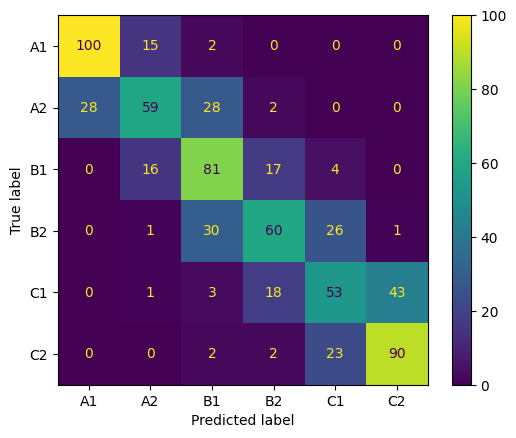

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["A1", "A2", "B1", "B2", "C1", "C2"])
disp.plot(cmap="viridis")


In [16]:
model.save_pretrained("./model/xlm-roberta-base-newdata-063")
tokenizer.save_pretrained("./model/xlm-roberta-base-newdata-063")

SyntaxError: invalid syntax (4045190663.py, line 2)

# Pairewise Mismmatch metric
The pairwise mismatch metric focuses on computing ordering violations in predictions relative to ground truth.
<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def pairwise_mismatch(y_pred: pd.Series, y_real: pd.Series) -> float:
    """
    Compute the pairwise mismatch metric as described by Henry Jamet.
    
    :param y_pred: Pandas Series of predicted difficulty levels
    :param y_real: Pandas Series of true difficulty levels
    :return: Mean pairwise mismatch score
    """
    predictions = pd.DataFrame({"pred": y_pred, "real": y_real})

    # Sort alphabetically by real and predicted labels
    predictions = predictions.sort_values(by=["real", "pred"])

    # Convert categorical labels into numeric values while keeping order
    predictions["pred"] = predictions["pred"].astype("category")
    predictions["real"] = predictions["real"].astype("category")

    # Initialize LabelEncoder and encode labels
    label_encoder = LabelEncoder()
    unique_labels = pd.unique(predictions[["pred", "real"]].values.ravel("K"))
    label_encoder.fit(unique_labels)

    predictions["pred"] = label_encoder.transform(predictions["pred"])
    predictions["real"] = label_encoder.transform(predictions["real"])

    # Compute the pairwise mismatch
    mismatch = (
        predictions["pred"].expanding().apply(lambda s: (s.iloc[-1] - s < 0).sum())
        + predictions["pred"][::-1]
        .expanding()
        .apply(lambda s: (s.iloc[-1] - s > 0).sum())[::-1]
    )

    return mismatch.mean()

# Convert y_true and y_pred into pandas Series
y_true_series = pd.Series(y_true)
y_pred_series = pd.Series(y_pred)

# Compute the pairwise mismatch
mismatch_score = pairwise_mismatch(y_pred_series, y_true_series)
print(f"Pairwise Mismatch Score: {mismatch_score:.4f}")


Pairwise Mismatch Score: 14.8596
